In [1]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
!conda install -c conda-forge geocoder --yes 
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geocoder:        1.38.1-py_1       conda-forge
    python_abi:    

### 1. Build the dataframe for the Toronto Neighbourhoods using BeautifulSoup.

In [2]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [3]:
df = pd.DataFrame(l, columns=["PostalCode", "Borough", "Neighbourhood"])
df.head(10)

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,None
1,M2A,Not assigned,None
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
7,M8A,Not assigned,None
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge


### 1.1 Clean up the dataframe for the Toronto neighbourhood.

In [4]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
# If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df.loc[df['Neighbourhood']=='Not assigned', ['Neighbourhood']] = 'Queen\'s Park'
df.head(10)

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,"Garden District, Ryerson"


### 2. Build the dataframe for Toronto neighbourhood population

In [6]:
# Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [7]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese


In [63]:
# get the data size
df.shape
df1.shape

(174, 12)

In [55]:
df1['Latitude'] = ''
df1['Longitude'] = ''

# dummy values in case that geocoder is not working for the day
df1['Latitude'] = 43.638093
df1['Longitude'] = -79.4665843

### 3. Find out the latitude and longitude for each neighbourhood.

In [62]:

# loop through the postal code to find out the latitude and longitude
for index, data in df1.iterrows():
    lat_lng_coords = None
    #print ('Now at PostalCode:', data['PostalCode'])
    #print ('Now at Neighbourhood:', data['Neighbourhood'])
    while(lat_lng_coords is None):
        #g = geocoder.google('{}, Toronto, Ontario'.format('PostalCode']))
        g = geocoder.google('{}, Toronto, Ontario'.format(data['Neighbourhood']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('Neighbourhood:', data['Neighbourhood'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])
    
# loop through the postal code to find out the latitude and longitude
for index, data in df.iterrows():
    lat_lng_coords = None
    print ('Now at PostalCode:', data['PostalCode'])
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(data['PostalCode']))
        lat_lng_coords = g.latlng
    data['Latitude'] = lat_lng_coords[0]
    data['Longitude'] = lat_lng_coords[1]
    print ('PostalCode:', data['PostalCode'], 'Latitude:', data['Latitude'], 'Longitude:', data['Longitude'])

KeyboardInterrupt: 

### 3.1 Print out the updated dataframe.

In [17]:
# print out the updated dataframe
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,,
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,,
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,,
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,,
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,,
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,,
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,,


In [18]:
# double check on the dataframe
print('The dataframe has {} neighborhoods.'.format(
        len(df1['Neighbourhood'].unique()),
        df1.shape[0]
    )
)

The dataframe has 174 neighborhoods.


### 3.3 Add the population weightage for each neighbourhood.

In [19]:
total_population = df1['Population'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,,,2.161626
170,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,,,2.007928
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,,,1.987065
86,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,,,1.898439
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,,,1.845247
98,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,,,1.834774
168,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,,,1.785929
44,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,,,1.515581
108,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,,,1.492110
139,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,,,1.448645


### 3.4 Display the top 10 populated neighbourhood in the barchart.

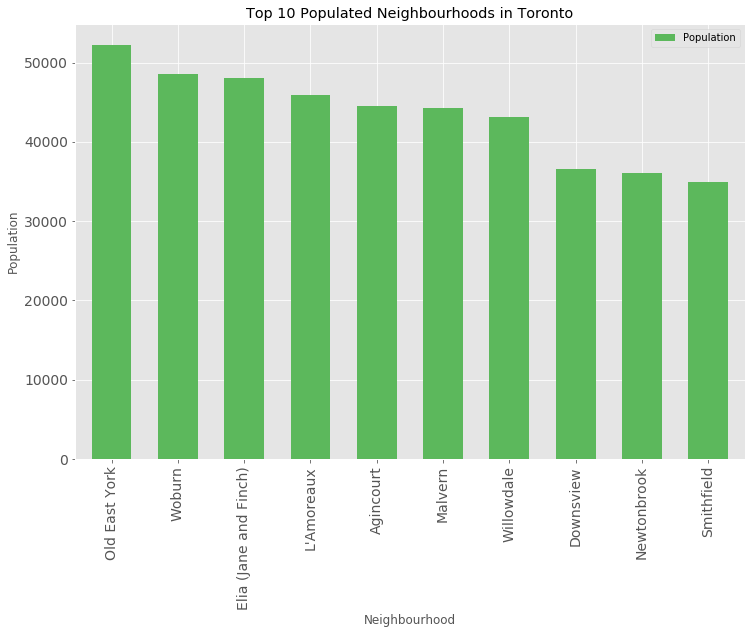

In [20]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#5cb85c', '#5bc0de', '#d9534f']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

### 4. Segmenting and clustering in Toronto.

In [21]:

# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.


The geograpical coordinate of Toronto Ontario are 43.6534817, -79.3839347.


### 4.1 - create the map of the Toronto Ontario and mark the neighbourhoods.

In [59]:
# create map of Toronto Ontario using latitude and longitude values
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_to)  

map_to

### 5. Adopting the Foursquare API to find out the venue category.

In [23]:
# Foursquare Credentials
CLIENT_ID = 'RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB' # your Foursquare ID
CLIENT_SECRET = '2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB
CLIENT_SECRET:2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ


### 5.1 Explore the first neighborhood in the dataframe

In [24]:
# explore the first neighborhood in our dataframe.
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,,,2.161626


In [65]:
neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format('Agincourt', 
                                                               '43.788009', 
                                                               '79.283882'))

Latitude and longitude values of Agincourt are 43.788009, 79.283882.


### 5.2 Explore the top venues from Foursquare API of radius of 500M.

In [26]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RF2HLDBFJ0Z0IAOHHOTQG4CMUCDM0RGVAF3DVCQFD153FMOB&client_secret=2LYBEQRR5TXMPQWUFKMLWCIKWVOA2G3U3Y1YCYL20MWXKRHJ&v=20180605&ll=,&radius=500&limit=100'

In [66]:
results = requests.get(url).json()
results

{'meta': {'code': 400,
  'errorType': 'param_error',
  'errorDetail': 'll must be of the form XX.XX,YY.YY (received ,)',
  'requestId': '5e9ede4c0be7b4001c249e9b'},
 'response': {}}

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:

# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

KeyError: 'groups'

In [30]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

NameError: name 'nearby_venues' is not defined

In [31]:

# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 5.3 Get nearby venues for Toronto neighbourhoods.

In [58]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux


KeyboardInterrupt: 

### 5.4 Find out how many unique categories in the result.

In [33]:
# find out how many unique categories
toronto_venues.groupby('Neighbourhood').count()

NameError: name 'toronto_venues' is not defined

In [34]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

NameError: name 'toronto_venues' is not defined

### 5.5 Analyzing each neighborhood now in Toronto.

In [35]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

NameError: name 'toronto_venues' is not defined

In [36]:
toronto_onehot.shape

NameError: name 'toronto_onehot' is not defined

### 5.6 Group the rows together based on the mean of the frequency of occurrence of each category.

In [37]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

NameError: name 'toronto_onehot' is not defined

In [38]:
toronto_grouped.shape

NameError: name 'toronto_grouped' is not defined

### 5.7 Find out the top 10 most common venues in the neighbourhood

In [39]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

NameError: name 'toronto_grouped' is not defined

In [40]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [41]:
toronto_grouped.shape[0]
toronto_grouped.head()

NameError: name 'toronto_grouped' is not defined

### 5.8 Explore the top 8 venues for each neighborhood.

In [42]:

# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

NameError: name 'toronto_grouped' is not defined

In [43]:

neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score


### 5.10 Calculate the total weighted score for each neighbourhood.

In [44]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

### 6. Cluster the neighbourhoods using K-Clustering.

In [45]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Income', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language %', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score


In [46]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

ValueError: Found array with 0 sample(s) (shape=(0, 9)) while a minimum of 1 is required.

### 6.1 Clean up the data for clustering.

In [47]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(0, 14)
(0, 9)


In [48]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score


In [49]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue


In [50]:

toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

NameError: name 'kmeans' is not defined

### 6.2 Draw the cluster map

In [51]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'

### 7. Evaluate the final result.

In [52]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score


In [53]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

KeyError: 'Cluster Labels'

In [71]:
# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

KeyError: 'Cluster Labels'

In [70]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

KeyError: 'Cluster Labels'

In [69]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

KeyError: 'Cluster Labels'

In [68]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

KeyError: 'Cluster Labels'


### 8. Final Analysis

Based on the result above, the first cluster (i.e. 0) looks to offer a higher number of similar neighborhoods and allow ABC Grocery to replicate their business offering quickly (due to the similarities in these neighborhoods) as part of their growth plan.

Within the first cluster, we will like to recommend a neighborhood with higher demand and lower supply to give ABC Grocery a higher advantage and chance to succeed upon their first service offering. Hence, with this in mind, it is apparent that neighborhood Humbermede looks to be the choice as it is the highest populated (i.e. 14,778) and very few Grocery stores in the neighborhood (i.e. close to none for the first few most common venues in this neighborhood).

It is also apparent that there is a high number of Punjabi people in that neighborhood and hence, we will also like to encourage the management of ABC Grocery to offer Punjabi food or related supplies in their service offerings in that neighborhood.

With that, we have concluded that the best recommendation for ABC Grocery to first offer their services in Toronto will be neighborhood Humbermede with the key factors to consider such as higher demand, lower competition, easy replication for business expansion. See the recommendation summary below.

1.Region: First Cluster.
2.Neighborhood: Humbermede
3.Additional Offering: Punjabi food or related supplies.

It is also recommended to the management of ABC Grocery to re-run this data science program to get the updated result and use the result into consideration as part of the business growth plan in selecting the next neighborhood to offer their services. This is critical not only to make sure that they got the updated result for better decision making, but also to make sure that they can re-validate the findings from this project. Finally, thank you for the opportunity in this project and we wish you the best success in your business.